### Operationalizing 
#### Individual Assignment 1
##### Talia Qaiser (Tqaiser)


In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
from sklearn.linear_model import Lasso

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow
from mlflow.models import infer_signature

In [37]:
# MLFlow Components
import mlflow
from mlflow.models import infer_signature

mlflow.set_experiment("MLflow Automatic Logging")
mlflow.autolog()

2024/02/21 14:11:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/02/21 14:11:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/02/21 14:11:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


### Data Setup and Preprocessing

In [38]:
df = pd.read_csv("Housing.csv")
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [39]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB
None


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [40]:
df.dtypes

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object

In [41]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

### EDA

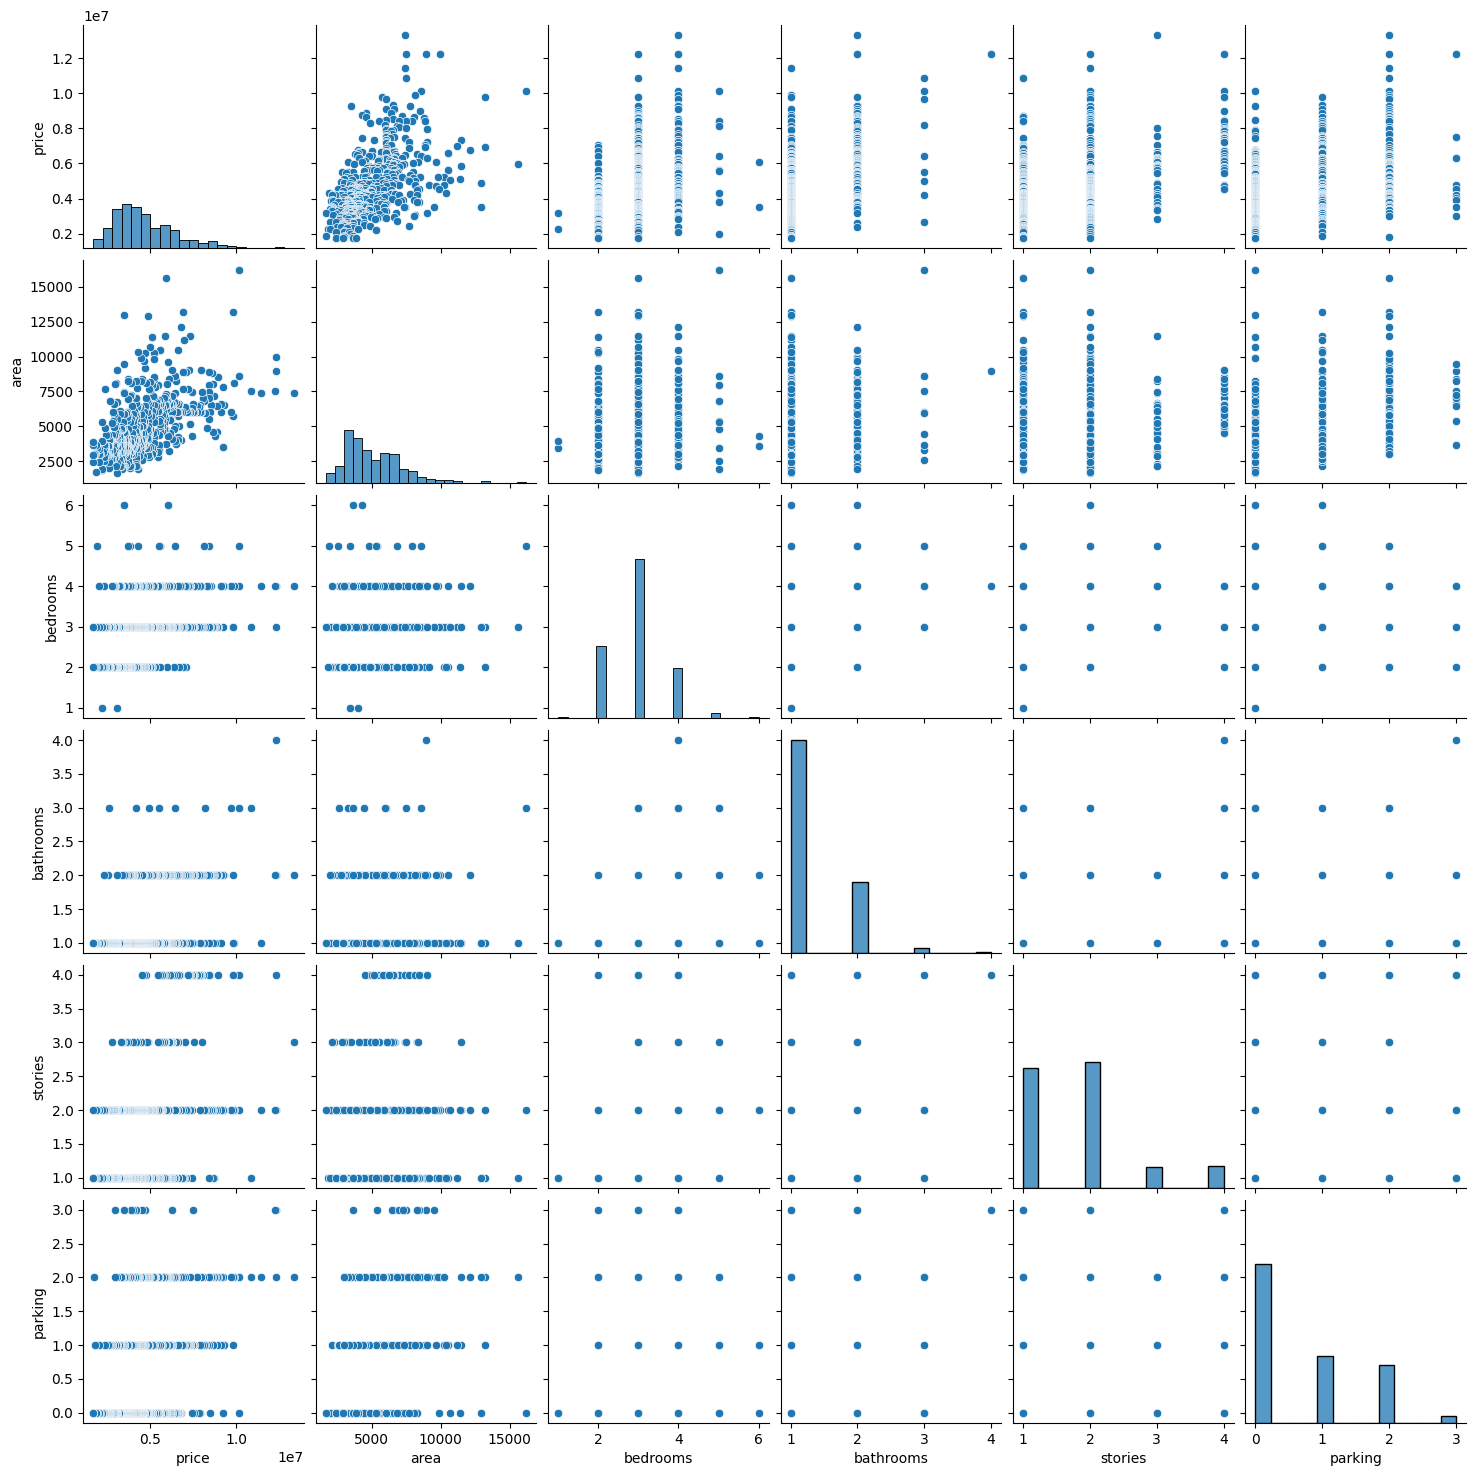

In [42]:
sns.pairplot(df)
plt.show()

In [43]:
## Price and area look interesting

<Axes: xlabel='price', ylabel='Count'>

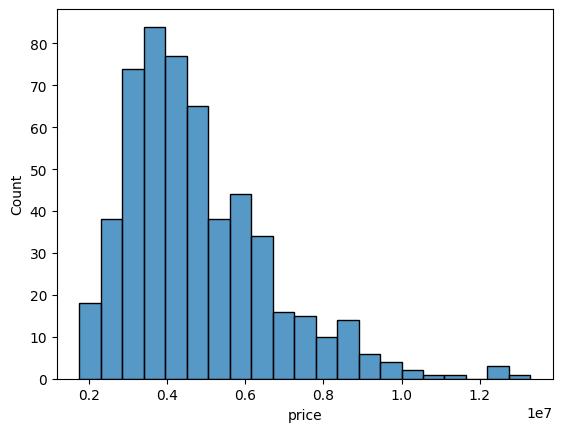

In [44]:
sns.histplot(data=df, x="price")


<Axes: xlabel='area', ylabel='Count'>

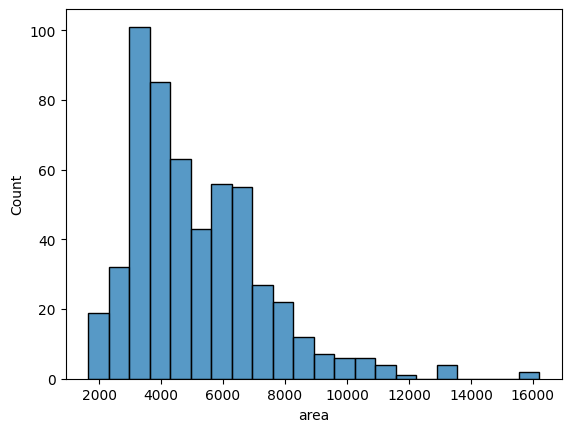

In [45]:
sns.histplot(data=df, x="area")

In [46]:
## Check correlation

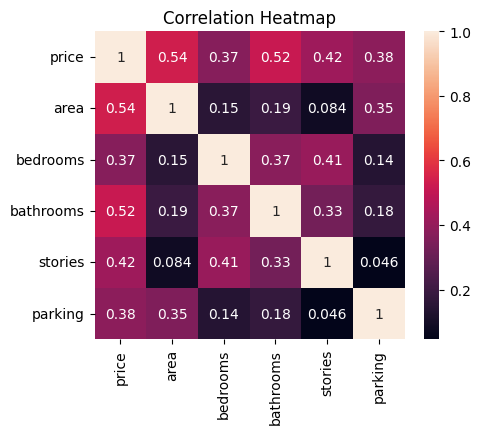

In [47]:
# Numeric variables
num_col = df.select_dtypes(include=['int64']).columns
num_col = df[num_col]

# Calculate correlation matrix
corr_matrix = num_col.corr()

# Plot correlation heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [50]:
# Categorical variables 
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['mainroad', 'guestroom', 'basement', 'hotwaterheating', 
                                                             'airconditioning', 'prefarea', 'furnishingstatus'], drop_first=True)

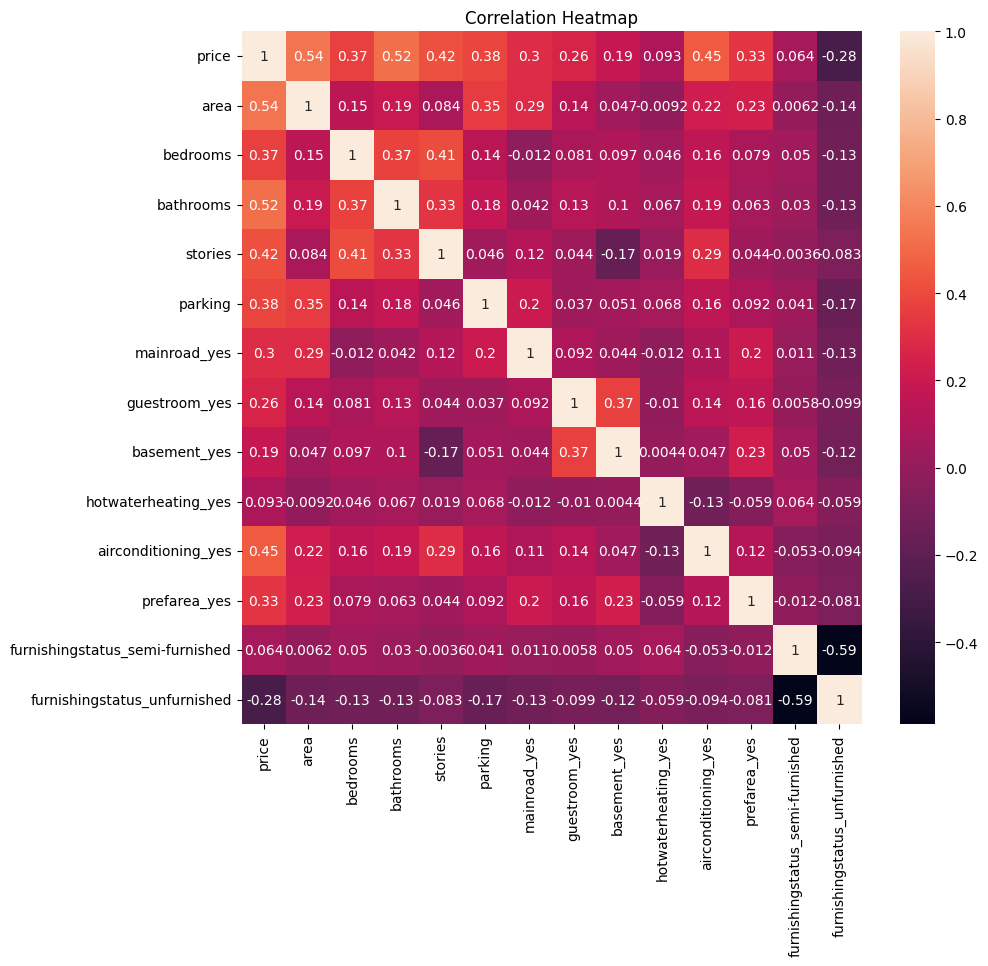

In [51]:
# Calculate correlation matrix
corr_matrix = df_encoded.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 9))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

The data has no missing values so not a lot of preprocessing is required. Then after some EDA, we get to see that there is a correlation between a few variables like price and area and price and bathrooms etc. 

In [52]:
# Identifying categorical and numerical columns
cat_cols = df_encoded.select_dtypes(include=['object']).columns
num_cols = df_encoded.select_dtypes(include=['int64']).columns

# Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Column transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols)])

### Machine Learning Model

#### Model 

In [53]:
mlflow.set_experiment("MLflow Housing Prediction")
mlflow.autolog()

2024/02/21 14:12:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/02/21 14:12:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/02/21 14:12:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [54]:
seed = 17

In [55]:
X = df_encoded[df_encoded.columns.difference(['price'])]
y = df_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)


In [56]:
from sklearn.tree import DecisionTreeRegressor

# Define the model hyperparameters
params_dt = {"max_depth": 50, "random_state": seed}

# Train the Decision Tree model
dt = DecisionTreeRegressor(**params_dt)
dt.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt.predict(X_test)

# MAE and MSE as loss metrics for Decision Tree
mae_dt = mean_absolute_error(y_test, y_pred_dt)
mse_dt = mean_squared_error(y_test, y_pred_dt)

# Display the metrics
print("Decision Tree Metrics:")
print("MAE:", mae_dt)
print("MSE:", mse_dt)


2024/02/21 14:12:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '37bce21b78a048a690aab08f68b8bc0f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/02/21 14:12:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With 

Decision Tree Metrics:
MAE: 1035644.8623853211
MSE: 1819055990422.9358


In [57]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_dt)

    # Log the loss metric
    mlflow.log_metrics({"MAE": mae_dt, "MSE": mse_dt})

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Decision Tree model to predict housing data")

    # Infer the model signature
    signature = infer_signature(X_train, dt.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=dt,
        artifact_path="house_prediction",
        signature=signature,
        input_example=X_train,
        registered_model_name="house-prediction-model",
    )


2024/02/21 14:12:22 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Python(65264) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Registered model 'house-prediction-model' already exists. Creating a new version of this model...
Created version '21' of model 'house-prediction-model'.


### Model Evaluation

In [58]:
print ("MAE: ", mae_dt)
print ("MSE: ", mse_dt)

MAE:  1035644.8623853211
MSE:  1819055990422.9358


### Use Model to Predict House Prices

In [59]:
# Use the loaded model to predict house prices on the test dataset (X_test)
predictions = dt.predict(X_test)

# Create a DataFrame 
result = pd.DataFrame()

# Add the actual house prices (y_test) to the DataFrame
result["Actual Price"] = y_test

# Add the predicted house prices to the DataFrame
result["Predicted Price"] = predictions



# Custom formatting function
def format_scientific_to_full(number):
    return "{:,.0f}".format(number)

# Apply the formatting function to the column
result["Predicted Price_formatted"] = result['Predicted Price'].apply(format_scientific_to_full)

# Show the first few rows of the DataFrame
result.head()

2024/02/21 14:12:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


,Actual Price,Predicted Price,Predicted Price_formatted
56,7343000,5215000.0,"5,215,000"
6,10150000,10850000.0,"10,850,000"
268,4382000,3360000.0,"3,360,000"
543,1750000,4200000.0,"4,200,000"
286,4235000,3780000.0,"3,780,000"


### Model Comparison

For Model Comparison, I chose the following two models:
1. from the Kaggle competition: https://www.kaggle.com/code/krparekh24/zillow-home-price-prediction
2. from github: https://github.com/Viveckh/LilHomie/blob/master/PricePredictionModel-RandomForest.ipynb

#### Model 1: CatBoost Regressor

In [60]:
from catboost import CatBoostRegressor

In [61]:
# Train the model
params_cbr = {"iterations": 630, "learning_rate": 0.03, "depth": 6, "l2_leaf_reg": 3, "random_seed": seed}
cbr = CatBoostRegressor(**params_cbr)
cbr.fit(X_train, y_train)

# Predict on the test set
y_pred_cbr = cbr.predict(X_test)

# MAE as loss metric
mae_cbr = mean_absolute_error(y_test, y_pred_cbr)
mse_cbr = mean_squared_error(y_test, y_pred_cbr)

0:	learn: 1908451.1689463	total: 4.01ms	remaining: 2.52s
1:	learn: 1886021.9102185	total: 4.47ms	remaining: 1.4s
2:	learn: 1861148.2367907	total: 5.65ms	remaining: 1.18s
3:	learn: 1837142.8390798	total: 6.31ms	remaining: 988ms
4:	learn: 1813450.9244767	total: 6.98ms	remaining: 872ms
5:	learn: 1791247.5721601	total: 7.66ms	remaining: 797ms
6:	learn: 1767362.9596637	total: 8.31ms	remaining: 740ms
7:	learn: 1744776.7669652	total: 9.12ms	remaining: 709ms
8:	learn: 1725115.3480586	total: 9.54ms	remaining: 658ms
9:	learn: 1704225.8512937	total: 10.2ms	remaining: 631ms
10:	learn: 1683556.5322967	total: 11.1ms	remaining: 623ms
11:	learn: 1662721.5584164	total: 12ms	remaining: 619ms
12:	learn: 1642205.8861999	total: 13ms	remaining: 617ms
13:	learn: 1625504.8090471	total: 13.6ms	remaining: 597ms
14:	learn: 1607158.9873952	total: 14.6ms	remaining: 601ms
15:	learn: 1590508.5027340	total: 15.8ms	remaining: 607ms
16:	learn: 1573140.5969004	total: 16.8ms	remaining: 606ms
17:	learn: 1556963.0698619	to

In [62]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_cbr)

    # Log the loss metric
    mlflow.log_metric("MAE_CBR", mae_cbr)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "CBR model for house prediction data")

    # Infer the model signature
    signature = infer_signature(X_train, cbr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=cbr,
        artifact_path="house_prediction",
        signature=signature,
        input_example=X_train,
        registered_model_name="house-prediction-model",
    )


/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Python(65268) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Registered model 'house-prediction-model' already exists. Creating a new version of this model...
Created version '22' of model

#### Model 2: Random Forest Regressor

In [63]:
# Train the model
params_rfr = {"n_estimators" : 100, "n_jobs" : -1}
rfr = RandomForestRegressor(**params_rfr)
rfr.fit(X_train, y_train)

# Predict on the test set
y_pred_rfr = rfr.predict(X_test)

# MAE as loss metric
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
mse_rfr = mean_squared_error(y_test, y_pred_rfr)


2024/02/21 14:12:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8b65c52c93a64e368e428863b022ae69', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2024/02/21 14:12:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/02/21 14:12:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/taliaqaiser/Library/Python/3

In [64]:
# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_rfr)

    # Log the loss metric
    mlflow.log_metric("MAE_RFR", mae_rfr)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Random Forest Regressor model for house prediction data")

    # Infer the model signature
    signature = infer_signature(X_train, rfr.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rfr,
        artifact_path="house_prediction",
        signature=signature,
        input_example=X_train,
        registered_model_name="house-prediction-model",
    )


2024/02/21 14:12:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
Python(65274) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Registered model 'house-prediction-model

In [65]:
model_metrics = {
    "DecisionTree": {"MAE": mae_dt},
    "CatBoostRegressor": {"MAE": mae_cbr},
    "RandomForestRegressor": {"MAE": mae_rfr}
}


                                MAE
DecisionTree           1.035645e+06
CatBoostRegressor      6.312058e+05
RandomForestRegressor  6.947618e+05


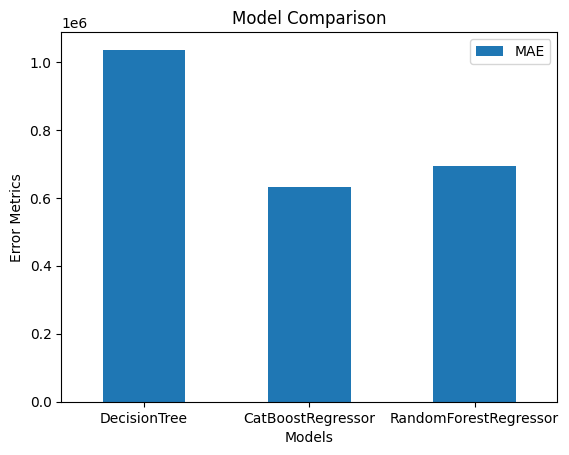

In [66]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert the dictionary to a Pandas DataFrame for better visualization
df_metrics = pd.DataFrame(model_metrics).T

# Display the DataFrame
print(df_metrics)

# Compare models using a bar plot
df_metrics.plot(kind="bar", y=["MAE"], rot=0)
plt.title("Model Comparison")
plt.xlabel("Models")
plt.ylabel("Error Metrics")
plt.show()


### Model Serving

In [67]:
import mlflow

# Specify the experiment name and filter criteria
experiment_name = "MLflow Housing Prediction"
filter_string = "tags.mlflow.source.type='LOCAL'"

# Get the run ID using the MLflow API
runs = mlflow.search_runs(experiment_ids=mlflow.get_experiment_by_name(experiment_name).experiment_id, filter_string=filter_string)
run_id = runs.iloc[0]["run_id"]  # Assuming you want the first run, adjust as needed


In [68]:
!mlflow models serve -m runs:/{run_id}/house_prediction -h 0.0.0.0 -p 5001


Python(65280) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
2024/02/21 14:12:49 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
Traceback (most recent call last):
  File "/Users/taliaqaiser/Library/Python/3.9/bin/mlflow", line 8, in <module>
    sys.exit(cli())
  File "/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
  File "/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Users/taliaqaiser/L

#### Simple Client to interact with the model

In [72]:
# Get the model URI
model_uri = mlflow.get_run(run_id).info.artifact_uri + "/model"

In [73]:
# import requests
# from urllib.parse import quote

# # Define the URL for the model serving endpoint
# # Encode the local file path
# model_uri_encoded = "file://" + quote(model_uri)

# # Define the URL for the model serving endpoint
# model_serving_url = model_uri_encoded 

# # Example data for inference 
# data = {
#     "max_depth": 50
# }

# # Make a POST request to the model serving endpoint with the input data
# response = requests.post(model_serving_url, json=data)

# # Check if the request was successful (status code 200)
# if response.status_code == 200:
#     # Parse the response JSON to get the model prediction
#     result = response.json()
#     print("Model Prediction:", result)
# else:
#     print("Error:", response.status_code, response.text)


I tried model serving and that ran okay but the simple client to interact with the model is unable to run. I tried multiple times. But I have followed all steps. 

In [74]:
!mlflow ui

Python(65292) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[2024-02-21 14:13:09 -0500] [65293] [INFO] Starting gunicorn 21.2.0
[2024-02-21 14:13:09 -0500] [65293] [INFO] Listening at: http://127.0.0.1:5000 (65293)
[2024-02-21 14:13:09 -0500] [65293] [INFO] Using worker: sync
[2024-02-21 14:13:09 -0500] [65294] [INFO] Booting worker with pid: 65294
/Users/taliaqaiser/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[2024-02-21 14:13:09 -0500] [65295] [INFO] Booting worker with pid: 65295
[2024-02-21 14:13:09 -0500] [65296] [INFO] Booting worker with pid: 65296
/

#### References:
1. ChatGPT
2. Recitation notes
3. ML class and EDA class notes